# 1. Alien vs Predator 데이터셋
Alien vs Predator 데이터셋은 컴퓨터 비전과 이미지 분류 모델을 학습시키기 위해 제공되는 소규모 데이터셋입니다. 이 데이터셋은 영화 속 캐릭터인 에일리언(Alien)과 프레데터(Predator)의 이미지로 구성되어 있습니다. 이 데이터를 통해 이 두 클래스를 분류하는 이미지 분류 모델을 학습시킬 수 있습니다.  


https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images

In [2]:
from google.colab import files
files.upload()  # kaggle.json 업로드 창 표시
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images

Dataset URL: https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images
License(s): ODbL-1.0
  0% 0.00/14.1M [00:00<?, ?B/s]
100% 14.1M/14.1M [00:00<00:00, 790MB/s]


In [4]:
!unzip -q alien-vs-predator-images.zip

# 2. Alexnet 모델을 활용한 Alien vs Predator 분류



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)), # 파이토치에서 만든 알렉스넷은 224를 받을겨
        # 각도, 찌그러뜨림, 크기
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        # 수평으로 뒤집기
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)), # 데이터 비교하기 위해서 Resize는 맞춰주기
        transforms.ToTensor()
    ])
}

In [8]:
# 레이블(정수)을 FloatTensor 형태로 변환해 주는 함수
def target_transforms(target):
    return torch.FloatTensor([target])

# ImageFolder: 이미지 폴더 안에 있는 걸 다 갖고 와서 데이터셋으로 만들어주는 것
# 이미지 폴더 구조를 기반으로 학습/검증용 데이터셋을 생성
image_datasets = {
    # 'train' 데이터셋
    # - data/train 폴더 안의 클래스별 하위폴더를 찾아 이미지와 정수 레이블을 자동으로 로드
    # - data_transforms['train']를 통해 이미지 전처리(transform) 적용
    # - target_transforms 함수를 통해 정수 레이블을 FloatTensor로 변환
    'train': datasets.ImageFolder(
        'data/train',
        transform=data_transforms['train'],
        target_transform=target_transforms
    ),
    # 'validation' 데이터셋
    # - data/validation 폴더 안의 클래스별 하위폴더를 찾아 이미지와 정수 레이블을 자동으로 로드
    # - data_transforms['validation']를 통해 이미지 전처리(transform) 적용
    # - target_transforms 함수를 통해 정수 레이블을 FloatTensor로 변환
    'validation': datasets.ImageFolder(
        'data/validation',
        transform=data_transforms['validation'],
        target_transform=target_transforms
    )
}


In [9]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'], # 데이터 셋을 넣어야 되니까
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

In [10]:
print(len(image_datasets['train']), len(image_datasets['validation']))
# 각각 가져다가 32개씩 쪼갠 것 나머지가 남으면 버린다 (기본 값이 버리는 것)

694 200


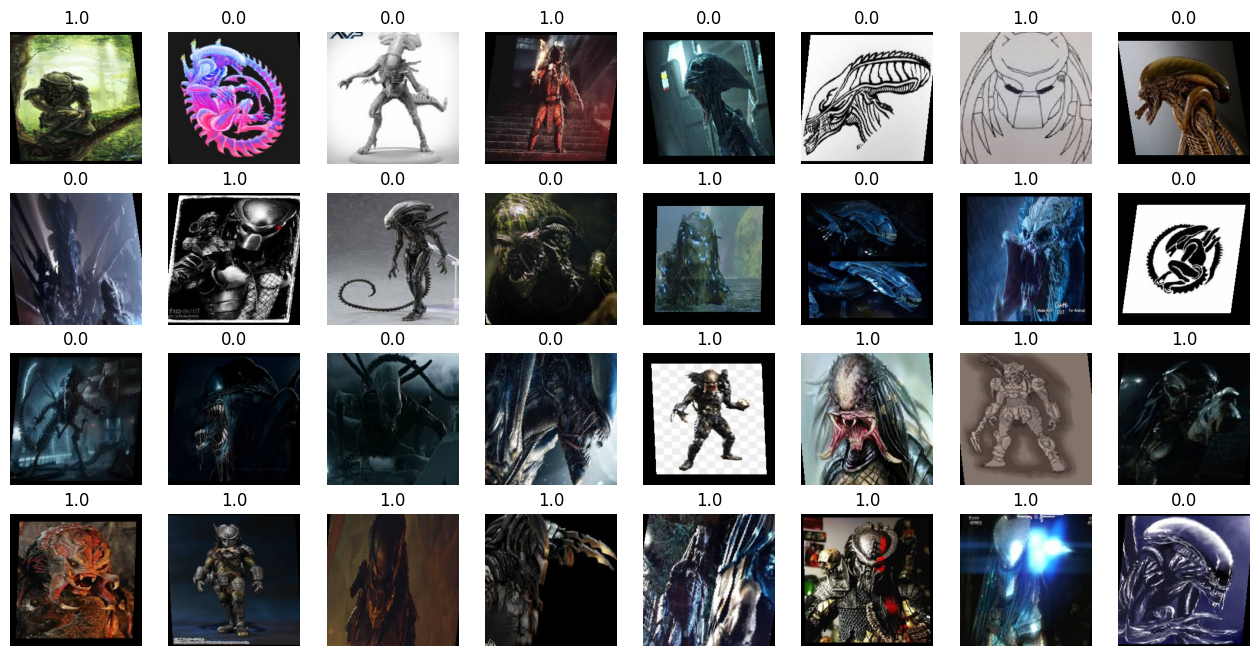

In [11]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
# 1줄로 flatten 시켜서, 이미지와 라벨 가져오는데,
for ax, img, label in zip(axes.flatten(), imgs, labels):
    # 이미지로 볼 땐, permute 해줘야 한다. (컬러를 맨 뒤로 보내줘야 함)
    ax.imshow(img.permute(1, 2, 0)) # (3, 224, 224) -> (224, 224, 3)
    ax.set_title(label.item())
    ax.axis('off')

# 3. 전이 학습
전이 학습(Transfer Learning)은 이미 학습된 모델(주로 대규모 데이터셋에서 사전 학습된 딥러닝 모델)을 새로운 문제에 적용하여 학습 시간을 단축하고 성능을 향상시키는 방법입니다. 기존 모델이 학습한 특징(Feature)을 활용해, 새로운 데이터셋에서 모델의 일부(주로 마지막 레이어)만 다시 학습하거나 추가 학습(Fine-tuning)을 진행합니다. 이는 특히 데이터가 적거나 학습 리소스가 제한된 상황에서 효과적이며, 이미지 분류(예: ResNet, VGG), 자연어 처리(예: BERT, GPT) 등 다양한 분야에서 널리 사용됩니다.  

요약 : 이미 학습된 가중치를 다른 학습에 적용해서, 추가로 학습하던가 아님 그대로 적용하던가

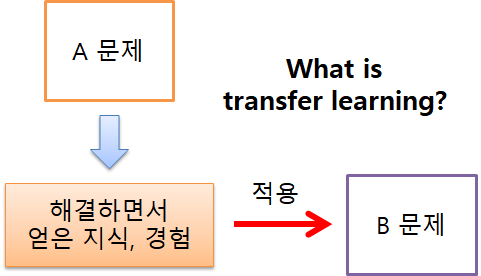

In [12]:
model = models.alexnet(weights='IMAGENET1K_V1').to(device)
print(model) # 가중치를 넣었기 때문에 cnn 쪽은 이미 학습이 되었다고 볼 수 있다.
# fc 레이어는 건들여야한다. (avgpool 기준 아래쪽)
# 얘도 1000개로 내보내기 때문에, 2개로 내보내야하니까 수정해야한다.
# cnn : 이미지 특징 추출은 잘 해주는데, 구분해주는 히든 레이어쪽은 내 입맛에 맞게 수정해야한다.
# model freezing 방법을 사용해볼 것

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 113MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### ※ 이미지넷

이미지넷(ImageNet)은 대규모 이미지 데이터셋으로, 컴퓨터 비전 연구와 딥러닝 모델 학습에 널리 사용됩니다. 2009년 스탠포드 대학의 페이페이 리(Fei-Fei Li) 교수팀이 구축했으며, 약 1,400만 장의 이미지와 22,000개 이상의 카테고리로 구성되어 있습니다. 이 중, 가장 널리 사용되는 ILSVRC(Imagenet Large Scale Visual Recognition Challenge) 버전은 약 1,000개의 클래스와 120만 장의 이미지를 포함합니다. 이미지넷은 모델이 객체를 분류하고 특징을 학습하는 데 필요한 풍부한 데이터와 레이블을 제공하며, ResNet, VGG, Inception 등 여러 혁신적인 모델이 이미지넷 대회를 통해 개발되었습니다. 이 데이터셋은 특히 사전 학습(Transfer Learning)에서 중요한 역할을 하며, 딥러닝 연구의 표준 벤치마크로 자리 잡았습니다.

In [13]:
for param in model.parameters():
    param.requires_grad = False # 가져온 파라미터를 업데이트 하지 않음

### ※ Model Freezing

Model Freezing은 전이 학습(Transfer Learning)에서 사전 학습된 모델의 일부 또는 전체 계층의 가중치를 고정하여 학습되지 않도록 설정하는 기법입니다. 주로 사전 학습된 모델의 초기 계층(Convolutional Layers 등)은 일반적인 특징(예: 가장자리, 패턴)을 학습했으므로 고정하고, 새로운 데이터셋에 특화된 특징을 학습하기 위해 최상위 계층(분류 헤드 등)만 학습합니다. 이 방법은 학습할 가중치의 수를 줄여 계산 비용을 절감하고, 과적합을 방지하며, 데이터가 부족한 상황에서 특히 유용합니다. 필요에 따라, 초기 학습이 끝난 후 일부 계층을 고정 해제(Fine-Tuning)하여 모델을 더 정교하게 조정할 수도 있습니다.

```
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 113MB/s]
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )
)
```
각각 model.안에 classifier, avgpool, features로 접근 가능하다.

In [14]:
model.classifier = nn.Sequential(
    nn.Linear(256 * 6 * 6, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)
# 모델을 수정하고 device로 보내준 것

print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_featur

In [15]:
# 학습
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10 Loss: 0.4765 Accuracy: 74.30%
validation: Epoch    1/10 Loss: 0.3235 Accuracy: 87.05%
train     : Epoch    2/10 Loss: 0.2962 Accuracy: 86.82%
validation: Epoch    2/10 Loss: 0.3912 Accuracy: 83.04%
train     : Epoch    3/10 Loss: 0.2258 Accuracy: 90.50%
validation: Epoch    3/10 Loss: 0.3513 Accuracy: 82.14%
train     : Epoch    4/10 Loss: 0.1445 Accuracy: 94.33%
validation: Epoch    4/10 Loss: 0.2031 Accuracy: 91.07%
train     : Epoch    5/10 Loss: 0.1336 Accuracy: 94.96%
validation: Epoch    5/10 Loss: 0.1950 Accuracy: 92.41%
train     : Epoch    6/10 Loss: 0.1331 Accuracy: 94.96%
validation: Epoch    6/10 Loss: 0.1784 Accuracy: 93.30%
train     : Epoch    7/10 Loss: 0.1001 Accuracy: 96.46%
validation: Epoch    7/10 Loss: 0.2045 Accuracy: 91.07%
train     : Epoch    8/10 Loss: 0.1103 Accuracy: 96.18%
validation: Epoch    8/10 Loss: 0.1801 Accuracy: 93.75%
train     : Epoch    9/10 Loss: 0.1055 Accuracy: 95.60%
validation: Epoch    9/10 Loss: 0.2255 Accuracy:

In [16]:
from PIL import Image

In [107]:
img1 = Image.open('/content/data/validation/alien/KakaoTalk_20250408_105306695_01.webp')
img2 = Image.open('/content/data/validation/predator/11.jpg')

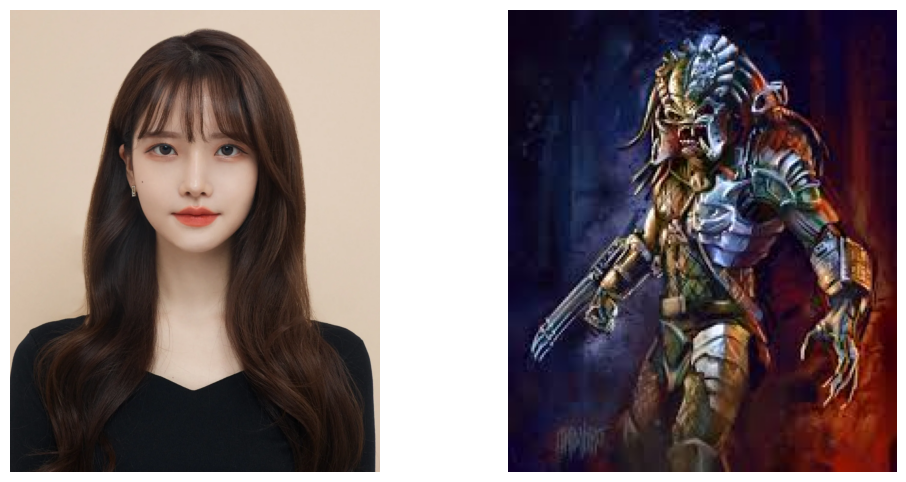

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [109]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape) # torch.Size([3, 224, 224])
print(img2_input.shape) # torch.Size([3, 224, 224])
# 컬러가 앞으로 간 거 보니 텐서로 만들어짐

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [110]:
# test_batch라는 변수를 만들어서 .stack이라는 걸 써볼게요
# img1과 2가 따로 놀고 있는 걸 합쳐준다. -> 이미지 2개의 배치가 된다.
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape # torch.Size([2, 3, 224, 224]) 모델에 32배치까지 넣을 수 있으니까 2개는 충분히 넣을 수 있음!

torch.Size([2, 3, 224, 224])

In [111]:
y_pred = model(test_batch)
y_pred
# 0.5를 기준으로 아래는 A, 위는 P

tensor([[0.2328],
        [0.9999]], grad_fn=<SigmoidBackward0>)

(np.float64(-0.5), np.float64(205.5), np.float64(244.5), np.float64(-0.5))

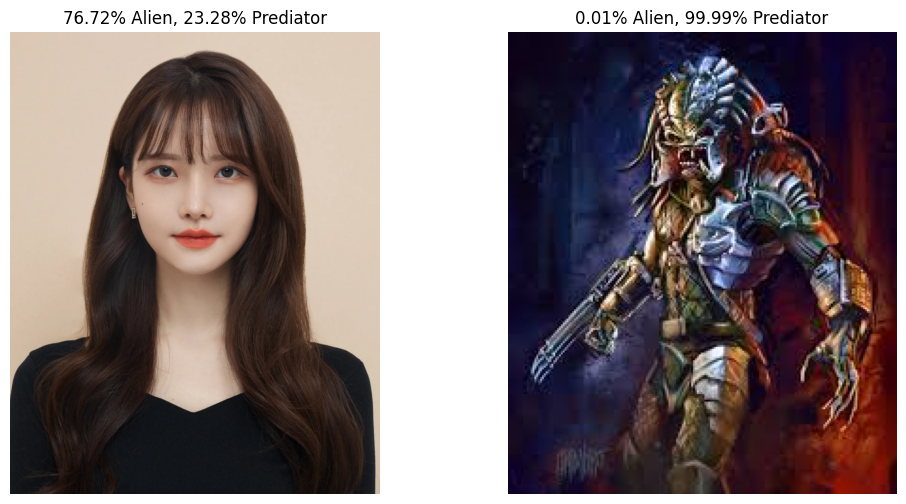

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f'{(1-y_pred[0, 0])*100:.2f}% Alien, {(y_pred[0, 0])*100:.2f}% Prediator')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1, 0])*100:.2f}% Alien, {(y_pred[1, 0])*100:.2f}% Prediator')
axes[1].imshow(img2)
axes[1].axis('off')